In [339]:
from tensorflow.keras.models import load_model
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import itertools
import numpy as np
from tqdm import tqdm
from pyathena import connect
import pickle
conn = connect(s3_staging_dir='s3//:nyg-hackathon-811331780957/ohsaquonuc/',
               work_group = 'ohsaquonuc',
               region_name = 'us-east-1')

In [243]:
model = load_model('time_model.h5')

In [304]:
def distance(x1, x2, y1, y2):
    return (((x2-x1)**2)+((y2-y1)**2))**.5

def deg_to_rad(x1, x2, y1, y2, deg):
    initial_angle = (deg*math.pi)/180
    diff_x = x2 - x1
    diff_y = y2 - y1
    return math.atan2(math.cos(initial_angle)*diff_y - diff_x * math.sin(initial_angle),
                      diff_x*math.cos(initial_angle)+diff_y*math.sin(initial_angle))

def deg_to_negative(x):
        if x.all() == 180:
            return 0
        elif x.all() < 180:
            return x-180
        elif x.all() > 180:
            return x-180
        
        
# Pipeline Functions #
        
def ready_columns(dataframe):
    dataframe_cols = list(dataframe.columns)
    dataframe_cols.remove('position')
    dataframe_cols.remove('firstname')
    dataframe_cols.remove('lastname')
    dataframe_cols.remove('offense_or_defense')
    for i in dataframe_cols:
        dataframe[i] = pd.to_numeric(dataframe[i])      
    return dataframe

def expandgrid(*itrs):
    product = list(itertools.product(*itrs))
    return {'Var{}'.format(i+1):[x[i] for x in product] for i in range(len(itrs))}

def expanded_grid(df1):
    df1['key'] = 1
    df2 = pd.DataFrame(expandgrid(np.arange(0,101,1), np.arange(0,55,1)))
    df2['key'] = 1  
    df3 = pd.merge(df1,df2,on='key').drop('key',axis=1)
    df3 = df3.rename(columns={'Var1' : 'free_x', 'Var2' : 'free_y'})
    return df3

def create_inputs(df1):
    df1['distance'] = 0
    for i in range(len(df1)):
        df1['distance'][i] = distance(df1['player_x'][i], df1['free_x'][i], df1['player_y'][i], df1['free_y'][i])
    df1['angle_in_radians'] = 0
    for i in range(len(df1)):
        df1['angle_in_radians'][i] = deg_to_rad(df1['player_x'][i], df1['free_y'][i], df1['player_y'][i], df1['free_y'][i], df1['player_direction_in_degrees'][i])
    return df1

def pred(df1, model_name):
    nn_model = load_model(model_name)
    df_x = df1[['player_directional_acceleration', 'weight', 'height', 'distance', 'angle_in_radians']]
    df_x_ss = x_ss.transform(df_x)
    df1['time'] = nn_model.predict(df_x_ss)
    return df1
    
def extract_probs(df1):
    probs = {}

    for x in np.arange(0,101,1):
        probs[f'{x}'] = []

    for x in np.arange(0,101,1):
            for y in np.arange(0,55,1):
                free_xy_frame = df1[(df1['free_x']==x) & (df1['free_y']==y)]
                smallest_times = free_xy_frame.nsmallest(n=10, columns='time')            
                probs[f'{x}'].append(smallest_times['offense_or_defense'].sum()/10)
    probs_frame = pd.DataFrame(probs)
    return probs_frame

def extract_owner(df1):
    probs = {}

    for x in np.arange(0,101,1):
        probs[f'{x}'] = []

    for x in np.arange(0,101,1):
            for y in np.arange(0,55,1):
                free_xy_frame = df1[(df1['free_x']==x) & (df1['free_y']==y)]
                smallest_times = free_xy_frame.nsmallest(n=1, columns='time')            
                probs[f'{x}'].append(smallest_times['offense_or_defense'].sum()/1)
    probs_frame = pd.DataFrame(probs)
    return probs_frame
    

    









In [245]:
df = pd.read_sql("""select firstname, lastname, position, player_x, player_y, player_speed, player_direction_in_degrees, player_directional_acceleration, weight, height from ohsaquonuc.all_tracking_data TABLESAMPLE BERNOULLI (0.3);""", conn)

In [246]:
df['player_x'].count()

1417860

In [247]:
df['random_x'] = 0
df['random_y'] = 0

for x in tqdm(range(len(df))):
    df['random_x'][x] = random.randint(0,101)
    df['random_y'][x] = random.randint(0,55)

  0%|          | 0/1417860 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 1417860/1417860 [02:59<00:00, 7892.07it/s]


In [252]:
df_cols = list(df.columns)
df_cols.remove('position')
df_cols.remove('firstname')
df_cols.remove('lastname')
for i in df_cols:
    df[i] = pd.to_numeric(df[i])
    
df['distance'] = distance(df['player_x'], df['random_x'], df['player_y'], df['random_y'])

df['angle_in_radians'] = 0

for i in tqdm(range(len(df))):
    df['angle_in_radians'][i] = deg_to_rad(df['player_x'][i], df['random_x'][i], df['player_y'][i], df['random_y'][i], df['player_direction_in_degrees'][i])

  0%|          | 0/1417860 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 1417860/1417860 [04:31<00:00, 5215.66it/s]


In [253]:
df.head()

,firstname,lastname,position,player_x,player_y,player_speed,player_direction_in_degrees,player_directional_acceleration,weight,height,random_x,random_y,distance,angle_in_radians
0,Linval,Joseph,DT,75.20,23.86,0.02,330.67,0.20,329.000000,76.000000,87,48,26.869678,1
1,Christopher,Jones,DT,75.42,22.12,0.02,1.49,0.02,309.722271,75.018037,12,33,64.346490,2
2,Tim,McDonald,SS,84.42,28.67,1.42,273.71,0.38,207.599873,72.127077,75,19,13.499826,0
3,Tim,McDonald,SS,15.02,29.90,1.49,244.67,0.12,207.599873,72.127077,76,22,61.489596,1
4,Jordan,Phillips,DT,23.89,27.07,0.37,103.19,0.18,341.000000,78.000000,63,22,39.437254,-1


In [254]:
new_data = df[['distance', 'player_speed', 'angle_in_radians']]
new_data = new_data.rename(columns={'player_speed':'speed', 'angle_in_radians':'angle'})
new_data.head()


,distance,speed,angle
0,26.869678,0.02,1
1,64.346490,0.02,2
2,13.499826,1.42,0
3,61.489596,1.49,1
4,39.437254,0.37,-1


In [255]:
df['time'] = model.predict(new_data)

In [256]:
df.head()

,firstname,lastname,position,player_x,player_y,player_speed,player_direction_in_degrees,player_directional_acceleration,weight,height,random_x,random_y,distance,angle_in_radians,time
0,Linval,Joseph,DT,75.20,23.86,0.02,330.67,0.20,329.000000,76.000000,87,48,26.869678,1,3.536839
1,Christopher,Jones,DT,75.42,22.12,0.02,1.49,0.02,309.722271,75.018037,12,33,64.346490,2,7.658607
2,Tim,McDonald,SS,84.42,28.67,1.42,273.71,0.38,207.599873,72.127077,75,19,13.499826,0,1.948640
3,Tim,McDonald,SS,15.02,29.90,1.49,244.67,0.12,207.599873,72.127077,76,22,61.489596,1,7.411058
4,Jordan,Phillips,DT,23.89,27.07,0.37,103.19,0.18,341.000000,78.000000,63,22,39.437254,-1,4.923162


In [ ]:
# New Model #

In [259]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [260]:
df_x = df[['player_directional_acceleration', 'weight', 'height', 'distance', 'angle_in_radians']]
df_y = df[['time']]

train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, test_size=0.33, random_state=3)

x_ss = StandardScaler(with_mean=True)
y_ss = StandardScaler(with_mean=True)
train_x = x_ss.fit_transform(train_x)
train_y = y_ss.fit_transform(train_y)
test_x = x_ss.transform(test_x)
test_y = y_ss.transform(test_y)

In [261]:
# Neural Network #

model = Sequential()
model.add(Dense(64, input_dim = 5, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse', 'mae'])

cp = ModelCheckpoint(filepath="space_owner_final.h5", save_best_only=True, verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = model.fit(train_x, train_y,
                    epochs=50,
                    batch_size=120,
                    shuffle=True,
                    validation_data=(test_x, test_y),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 949966 samples, validate on 467894 samples
Epoch 1/50
949966/949966 [==============================] - 25s 26us/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0478 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0429
Epoch 2/50
949966/949966 [==============================] - 23s 24us/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0401 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0386
Epoch 3/50
949966/949966 [==============================] - 23s 24us/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0391 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0390
Epoch 4/50
949966/949966 [==============================] - 23s 24us/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0388 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0413
Epoch 5/50
9

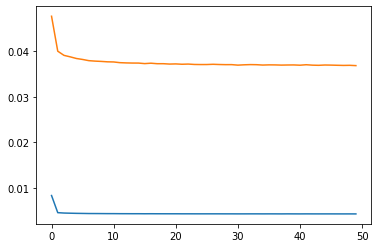

In [262]:
plt.plot(history['mean_squared_error'])
plt.plot(history['mean_absolute_error'])
plt.show()

In [358]:

# second_play = new_test = pd.read_sql("""select firstname, lastname, position, offense_or_defense, starttime, endtime, player_time, player_x, player_y, 
# player_speed, player_direction_in_degrees, player_directional_acceleration, weight, height, ball_x, ball_y
# from ohsaquonuc.all_tracking_data 
# where gameid = 2019092209
# and playid = 1789;""", conn)

In [ ]:
2019-09-08 20:33:44 

In [ ]:
# Pipeline #

In [442]:
new_test = pd.read_sql("""select firstname, lastname, position, offense_or_defense, player_x, player_y, 
player_speed, player_direction_in_degrees, player_directional_acceleration, weight, height 
from ohsaquonuc.all_tracking_data 
where gameid = 2019090810
and playid = 249
and player_time = '2019-09-08T20:33:49.000';""", conn)

2019-09-08 20:33:44 

#new_test['player_time'] = pd.to_datetime(new_test['player_time'])
#new_test['player_time'].min()

In [443]:
new_test.head()

,firstname,lastname,position,offense_or_defense,player_x,player_y,player_speed,player_direction_in_degrees,player_directional_acceleration,weight,height
0,Jonathan,Halapio,C,1,31.67,29.8,1.59,83.19,0.74,307.491940,75.943811
1,Cody,Core,WR,1,28.23,25.45,4.25,168.38,1.38,205.000000,75.000000
2,Lavonte,David,OLB,0,37.94,28.55,0.59,99.7,0.75,233.000000,73.000000
3,William,Hernandez,G,1,31.59,31.01,0.96,68.46,0.78,317.074452,76.373788
4,Marvin,Stewart,CB,0,38.26,27.53,0.91,123.48,0.6,195.269110,71.531181


In [444]:
step1 = ready_columns(new_test)
step2 = expanded_grid(step1)
step3 = create_inputs(step2)
step4 = pred(step3, 'space_owner_final.h5')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [446]:
step5 = extract_probs(step4)

In [447]:
step5.to_pickle('1789_starttime5.pickle')

In [305]:
step5_5 = extract_owner(step4)

In [306]:
step5_5

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


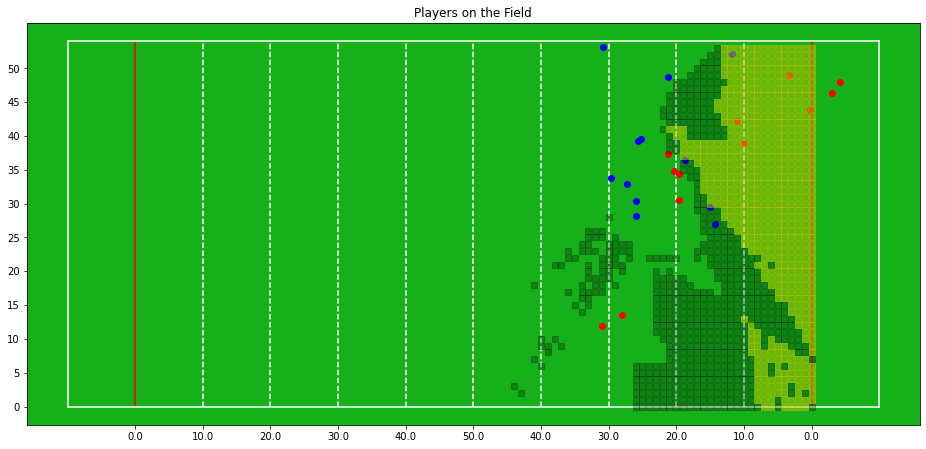

In [337]:
# TEST USE THIS!!!!!!!!!!!! #

y_maximums = [0, 0, 54, 54]
x_maximums = [0, 100, 0, 100]

fig=plt.figure(figsize=(16, 14))
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

plt.plot([x_maximums[0], x_maximums[2]], [y_maximums[0], y_maximums[2]], 'r')
plt.plot([x_maximums[1], x_maximums[3]], [y_maximums[1], y_maximums[3]], 'r')
plt.plot([x_maximums[0]-10, x_maximums[2]-10], [y_maximums[0], y_maximums[2]], 'w')
plt.plot([x_maximums[1]+10, x_maximums[3]+10], [y_maximums[1], y_maximums[3]], 'w')
plt.plot([x_maximums[0]-10, x_maximums[1]+10], [y_maximums[0], y_maximums[1]], 'w')
plt.plot([x_maximums[2]-10, x_maximums[3]+10], [y_maximums[2], y_maximums[3]], 'w')

for i in range(1,10):
    plt.plot([x_maximums[0]+i*10, x_maximums[2]+i*10], [y_maximums[0], y_maximums[2]], 'w--')

for i in range(len(step1)):
    if step1['offense_or_defense'][i] == 1:
        plt.plot(step1['player_x'][i], step1['player_y'][i], 'bo') 
    else:
        plt.plot(step1['player_x'][i], step1['player_y'][i], 'ro')
        
        
# Plot Ownership        
# for i in np.arange(0,101,1):
#     for j in np.arange(0,54,1):
#         if step5_5[f'{i}'][j] == 0.0:
#             plt.plot(i, j, 'ys', alpha=.5)
            
# Plot Ownership using Probabilities            
for i in np.arange(0,101,1):
    for j in np.arange(0,54,1):
        if step5[f'{i}'][j] < .5:
            plt.plot(i, j, 'ys', alpha=.5)
        if step5[f'{i}'][j] == .5:
            plt.plot(i, j, 'ks', alpha=.25)


            
plt.title('Players on the Field')
plt.yticks(np.arange(0, 55, step=5), np.arange(0,55, step=5))
plt.xticks(np.arange(0, 101, step=10), np.append(np.arange(0, 51, 10),(np.arange(-40, 1, step=10)**2)**.5))
plt.ylim(0,55)
plt.xlim(0,101)
plt.axis('scaled')
ax.set_facecolor('xkcd:green')


plt.show()

In [107]:
test

,player_x,player_y,player_speed,player_direction_in_degrees,weight,random_x,random_y,distance,angle_in_radians,time
0,102.29,21.84,0.00,319.93,286.000000,80,39,28.130228,2.442239,3.621397
1,105.29,13.25,0.00,238.74,194.000000,80,39,36.092196,1.025206,4.558860
2,105.13,40.77,0.01,183.27,209.000000,80,39,25.192257,0.057072,3.268810
3,95.92,12.63,0.08,327.77,191.000000,80,39,30.802976,2.579073,3.955586
4,102.36,27.85,0.01,105.50,293.000000,80,39,24.985838,-1.300270,3.188179
5,98.00,26.29,0.00,42.62,240.000000,80,39,22.035065,-2.397733,2.929698
6,104.35,25.66,0.00,235.62,317.132214,80,39,27.764692,0.970752,3.637013
7,103.92,24.04,0.00,109.26,307.481374,80,39,28.212905,-1.234646,3.556849
8,104.54,19.02,0.20,65.59,248.000000,80,39,31.645094,-1.996831,4.013354
9,102.41,24.84,0.00,109.39,311.000000,80,39,26.508748,-1.232377,3.361550


In [224]:
test = pd.read_sql("""select player_x, player_y, position, player_speed, player_direction_in_degrees, player_directional_acceleration, weight, height
from ohsaquonuc.all_tracking_data 
where starttime like '2018-10-21T14:25:45.893'
and gameid = 2018102100
and player_time = '2018-10-21T14:26:01.200';""", conn)

In [151]:
len(test)

22

In [152]:
test

,player_x,player_y,position,player_speed,player_direction_in_degrees,player_directional_acceleration,weight,height
0,102.36,27.85,NT,0.01,105.5,0.01,293.000000,74.000000
1,88.69,28.59,SS,0.01,142.48,0.01,195.000000,70.000000
2,98.77,16.11,SS,0.27,298.7,0.33,215.000000,74.000000
3,98.02,23.17,OLB,0,241.94,0,221.000000,71.000000
4,102.38,30.62,OLB,0.01,93.5,0.01,250.000000,75.000000
5,108.1,23.9,QB,0.04,105.15,0.02,222.000000,76.000000
6,102.41,24.84,NT,0,109.39,0,311.000000,73.000000
7,104.71,28.26,TE,0.67,321.37,1.66,253.983072,76.742658
8,104.38,20.81,T,0.39,92.17,0.11,309.000000,79.000000
9,104.72,27.07,T,0,64.9,0,308.000000,78.000000


In [237]:
test['random_x'] = 1
test['random_y'] = 1

# for x in tqdm(range(len(test))):
#     test['random_x'][x] = random.randint(0,101)
#     test['random_y'][x] = random.randint(0,55)

test_cols = list(test.columns)
test_cols.remove('position')
for i in test_cols:
    test[i] = pd.to_numeric(test[i])
    
test['distance'] = distance(test['player_x'], test['random_x'], test['player_y'], test['random_y'])

test['angle_in_radians'] = 0

for i in tqdm(range(len(test))):
    test['angle_in_radians'][i] = deg_to_rad(test['player_x'][i], test['random_x'][i], test['player_y'][i], test['random_y'][i], test['player_direction_in_degrees'][i])

newtest_data = test[['distance', 'player_speed', 'angle_in_radians']]
newtest_data = newtest_data.rename(columns={'player_speed':'speed', 'angle_in_radians':'angle'})

test['time'] = model.predict(newtest_data)

  0%|          | 0/22 [00:00<?, ?it/s]


AttributeError: module 'math' has no attribute 'atan2f'

In [235]:
test[test['angle_in_radians'] < 0]

,player_x,player_y,position,player_speed,player_direction_in_degrees,player_directional_acceleration,weight,height,random_x,random_y,distance,angle_in_radians,time
7,98.77,16.11,SS,0.27,298.70,0.33,215.000000,74.000000,1,1,98.930708,-1,11.601251
8,104.71,28.26,TE,0.67,321.37,1.66,253.983072,76.742658,1,1,107.232792,-2,12.777699
11,102.29,21.84,DT,0.00,319.93,0.00,286.000000,73.000000,1,1,103.411652,-2,12.269669
12,100.53,41.47,CB,0.58,297.07,0.26,192.000000,71.000000,1,1,107.443203,-1,12.560482
20,95.92,12.63,CB,0.08,327.77,0.21,191.000000,71.000000,1,1,95.629824,-2,11.383895


In [154]:
test[test['time']==test['time'].min()]

,player_x,player_y,position,player_speed,player_direction_in_degrees,player_directional_acceleration,weight,height,random_x,random_y,distance,angle_in_radians,time
1,88.69,28.59,SS,0.01,142.48,0.01,195.0,70.0,1,1,91.927929,-0.654848,10.757379


In [155]:
test[test['player_speed'] == test['player_speed'].max()]

,player_x,player_y,position,player_speed,player_direction_in_degrees,player_directional_acceleration,weight,height,random_x,random_y,distance,angle_in_radians,time
7,104.71,28.26,TE,0.67,321.37,1.66,253.983072,76.742658,1,1,107.232792,2.467372,12.609528


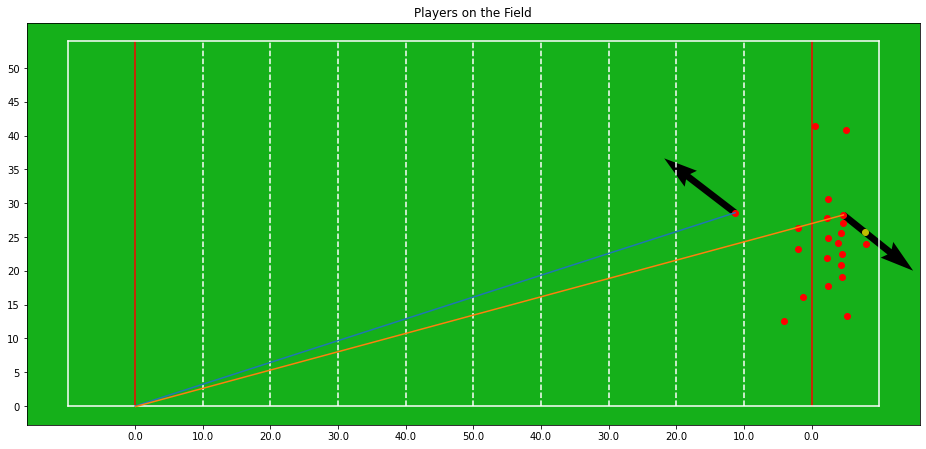

In [169]:
# TEST USE THIS!!!!!!!!!!!! #

y_maximums = [0, 0, 54, 54]
x_maximums = [0, 100, 0, 100]

fig=plt.figure(figsize=(16, 14))
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

plt.plot([x_maximums[0], x_maximums[2]], [y_maximums[0], y_maximums[2]], 'r')
plt.plot([x_maximums[1], x_maximums[3]], [y_maximums[1], y_maximums[3]], 'r')
plt.plot([x_maximums[0]-10, x_maximums[2]-10], [y_maximums[0], y_maximums[2]], 'w')
plt.plot([x_maximums[1]+10, x_maximums[3]+10], [y_maximums[1], y_maximums[3]], 'w')
plt.plot([x_maximums[0]-10, x_maximums[1]+10], [y_maximums[0], y_maximums[1]], 'w')
plt.plot([x_maximums[2]-10, x_maximums[3]+10], [y_maximums[2], y_maximums[3]], 'w')

for i in range(1,10):
    plt.plot([x_maximums[0]+i*10, x_maximums[2]+i*10], [y_maximums[0], y_maximums[2]], 'w--')

for i in range(len(test)):
    if test['position'][i] == 'RB':
        plt.plot(test['player_x'][i], test['player_y'][i], 'yo') 
    else:
        plt.plot(test['player_x'][i], test['player_y'][i], 'ro')
        
xtry, ytry = 88.69, 28.59 
endy = .01 * math.sin(math.radians(142.48))
endx = .01 * math.cos(math.radians(142.48))
plt.plot([xtry, endx], [ytry, endy])
plt.quiver(xtry, ytry, endx, endy, scale = .1)

xtry1, ytry1 = 104.71, 28.26 
endy1 = .01*10 * math.sin(math.radians(321.37))
endx1 = .01*10 * math.cos(math.radians(321.37))
plt.plot([xtry1, endx1], [ytry1, endy1])
plt.quiver(xtry1, ytry1, endx1, endy1, scale = 1)


plt.title('Players on the Field')
plt.yticks(np.arange(0, 55, step=5), np.arange(0,55, step=5))
plt.xticks(np.arange(0, 101, step=10), np.append(np.arange(0, 51, 10),(np.arange(-40, 1, step=10)**2)**.5))
plt.ylim(0,55)
plt.xlim(0,101)
plt.axis('scaled')
ax.set_facecolor('xkcd:green')


plt.show()

In [ ]:
### New Space Ownership Model ###

In [209]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [213]:
df_x = df[['player_directional_acceleration', 'weight', 'height', 'distance', 'angle_in_radians']]
df_y = df[['time']]

train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, test_size=0.33, random_state=3)

x_ss = StandardScaler(with_mean=True)
y_ss = StandardScaler(with_mean=True)
train_x = x_ss.fit_transform(train_x)
train_y = y_ss.fit_transform(train_y)
test_x = x_ss.transform(test_x)
test_y = y_ss.transform(test_y)

In [214]:
# Neural Network #

model = Sequential()
model.add(Dense(64, input_dim = 5, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse', 'mae'])

cp = ModelCheckpoint(filepath="space_owner.h5", save_best_only=True, verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = model.fit(train_x, train_y,
                    epochs=100,
                    batch_size=120,
                    shuffle=True,
                    validation_data=(test_x, test_y),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 791213 samples, validate on 389702 samples
Epoch 1/100
791213/791213 [==============================] - 20s 25us/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0652 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0579
Epoch 2/100
791213/791213 [==============================] - 19s 24us/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0551 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0569
Epoch 3/100
791213/791213 [==============================] - 20s 26us/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0539 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0539
Epoch 4/100
791213/791213 [==============================] - 19s 24us/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0533 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0514
Epoch 5/

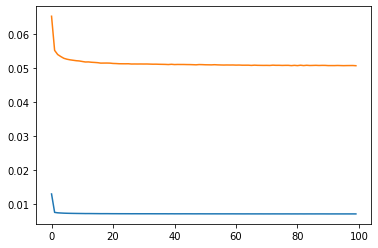

In [216]:
plt.plot(history['mean_squared_error'])
plt.plot(history['mean_absolute_error'])
plt.show()

In [217]:
test = pd.read_sql("""select player_x, player_y, position, player_speed, player_direction_in_degrees, player_directional_acceleration, weight, height
from ohsaquonuc.all_tracking_data 
where starttime like '2018-10-21T14:25:45.893'
and gameid = 2018102100
and player_time = '2018-10-21T14:26:01.200';""", conn)

In [218]:
test['random_x'] = 1
test['random_y'] = 1

# for x in tqdm(range(len(test))):
#     test['random_x'][x] = random.randint(0,101)
#     test['random_y'][x] = random.randint(0,55)

test_cols = list(test.columns)
test_cols.remove('position')
for i in test_cols:
    test[i] = pd.to_numeric(test[i])
    
test['distance'] = distance(test['player_x'], test['random_x'], test['player_y'], test['random_y'])

test['angle_in_radians'] = deg_to_rad(deg_to_negative(test['player_direction_in_degrees']))

newtest_data = test[['player_directional_acceleration', 'weight', 'height', 'distance', 'angle_in_radians']]
newtest_data = x_ss.transform(newtest_data)
# newtest_data = newtest_data.rename(columns={'player_speed':'speed', 'angle_in_radians':'angle'})

test['time'] = model.predict(newtest_data)

test.head()

,player_x,player_y,position,player_speed,player_direction_in_degrees,player_directional_acceleration,weight,height,random_x,random_y,distance,angle_in_radians,time
0,102.41,24.84,NT,0.00,109.39,0.00,311.0,73.0,1,1,104.174535,-1.232377,3.096367
1,98.00,26.29,ILB,0.00,42.62,0.00,240.0,71.0,1,1,100.242626,-2.397733,3.010757
2,102.38,30.62,OLB,0.01,93.50,0.01,250.0,75.0,1,1,105.618411,-1.509710,3.202938
3,102.36,27.85,NT,0.01,105.50,0.01,293.0,74.0,1,1,104.855959,-1.300270,3.141669
4,88.69,28.59,SS,0.01,142.48,0.01,195.0,70.0,1,1,91.927929,-0.654848,2.499860


In [219]:
test[test['time']==test['time'].min()]

,player_x,player_y,position,player_speed,player_direction_in_degrees,player_directional_acceleration,weight,height,random_x,random_y,distance,angle_in_radians,time
4,88.69,28.59,SS,0.01,142.48,0.01,195.0,70.0,1,1,91.927929,-0.654848,2.49986


In [220]:
test[test['player_directional_acceleration']==test['player_directional_acceleration'].max()]

,player_x,player_y,position,player_speed,player_direction_in_degrees,player_directional_acceleration,weight,height,random_x,random_y,distance,angle_in_radians,time
10,104.71,28.26,TE,0.67,321.37,1.66,253.983072,76.742658,1,1,107.232792,2.467372,3.496781


In [ ]:
timestep t:
each player has x, y, height, weight, da
diff points on field 100x54
